讀取資料

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data=pd.read_excel('/content/drive/MyDrive/守燦_碩士論文實作/TFC/TFC_Preprocess.xlsx')

Mounted at /content/drive


自然語言處理與GloVe模型建立

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


讀取資料集完成


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


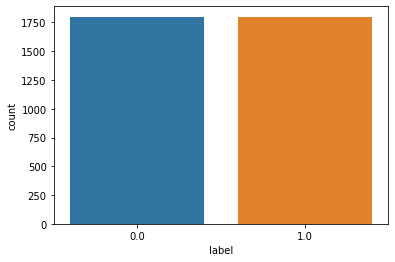

切割資料集-完成
標註與填充文字-完成


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Embedding Matrix: 
 [[ 0.17832896 -0.13721179 -0.24969604 ...  0.33441239  0.30825888
   0.05150009]
 [-0.214994   -0.43663999  0.62405002 ... -0.62654001  0.17057601
  -0.30815601]
 [-0.25061472  0.2928237  -0.34941052 ... -0.22474527 -0.08830224
   0.34467752]
 ...
 [ 0.44182632 -0.09061185  0.24680796 ... -0.09743019 -0.05568912
   0.02728749]
 [-0.01531392  0.37052971  0.18338986 ...  0.08343958 -0.20797371
  -0.16630597]
 [-0.12228371  0.23962906 -0.22202957 ...  0.30226251 -0.28327199
  -0.2323261 ]]
Embedding Matrix size:  (4893, 300)
建立GloVe預訓練模型-完成


In [2]:
#套件載入
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense
#讀取資料集
#data=pd.read_csv('news1_eda.csv')
print("讀取資料集完成")
#觀查label欄位資料平衡的狀況
sns.countplot(data['label'])
plt.show()
#定義X與Y
y=data["label"] #Fake或True
x=data['title'] #標題
#切割資料集
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print("切割資料集-完成")
#自然語言處理-標註向量與填充文字(Tokenization,Padding):用向量表示每個詞彙，以利後續GloVe模型建立。
max_len=300
tokenizer=text.Tokenizer(num_words=max_len) #標註內文的限制為內文最多300字，若少於300字則進行填充並截斷長字
tokenizer.fit_on_texts(x_train) #將內文所有詞彙的向量映射保存在Glove分詞器的word_index屬性中
tokenized_train=tokenizer.texts_to_sequences(x_train) #標註訓練集內文
x_train=sequence.pad_sequences(tokenized_train,maxlen=max_len) #填充訓練集內文
tokenized_test=tokenizer.texts_to_sequences(x_test) #標註測試集內文
x_test=sequence.pad_sequences(tokenized_test,maxlen=max_len) #填充測試集內文
print("標註與填充文字-完成")
#建立GloVe預訓練模型
max_features=4893 #詞彙共現矩陣的最大特徵為4893
embedding_file="/content/drive/MyDrive/守燦_碩士論文實作/預訓練資源檔/Glove_CNA_ASBC_300d.vec" #GloVe預訓練模型的檔案
def get_coeffs(word,*arr): #定義文字轉換為數字的運作方法
    return word,np.asarray(arr,dtype='float32')
embedding_index=dict(get_coeffs(*o.rstrip().rsplit(' ')) for o in open(embedding_file,encoding='utf-8')) #利用get_coeffs方法載入預訓練檔案，得到預訓練檔案的數值並儲存在字典中
embeds=np.stack(embedding_index.values()) #將字典裡的數值嵌入至新的序列
emb_mean,emb_std=embeds.mean(),embeds.std() #計算嵌入的平均數與標準差
embed_size=embeds.shape[1] #計算嵌入值序列的資料維度
word_index=tokenizer.word_index #Glove模型的分詞器
nb_words=min(max_features,len(word_index)) #定義最小特徵與最小維度需與GloVe分詞器一致
embedding_matrix=np.random.normal(emb_mean,emb_std,(nb_words,embed_size)) #詞彙共現性矩陣是經由嵌入的平均數、標準差、Glove分詞器三者的常態擬和求得
for word, i in word_index.items():#進行文字轉換為文字向量，完成預訓練，求出詞彙共現性矩陣
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
print("Embedding Matrix: \n",embedding_matrix)
print("Embedding Matrix size: ",embedding_matrix.shape)
print("建立GloVe預訓練模型-完成")

嵌入Glove至BiLSTM模型訓練

In [3]:
#定義BiLSTM模型參數
batch_size=64
epochs=20
embed_size=300
#建立BiLSTM模型
model=Sequential()
model.add(Embedding(max_features,output_dim=embed_size,weights=[embedding_matrix],input_length=max_len,trainable=False))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(32,return_sequences=False)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())
print("BiLSTM模型建立-完成")
#訓練BiLSTM模型
history=model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_test,y_test),epochs=epochs)
print("BiLSTM模型訓練-完成")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          1467900   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,697,053
Trainable params: 229,153
Non-tr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 15s 96ms/step - loss: 0.6944 - accuracy: 0.5040 - val_loss: 0.6912 - val_accuracy: 0.5306
Epoch 2/20
40/40 [==============================] - 2s 56ms/step - loss: 0.6899 - accuracy: 0.5187 - val_loss: 0.6880 - val_accuracy: 0.5306
Epoch 3/20
40/40 [==============================] - 2s 56ms/step - loss: 0.6845 - accuracy: 0.5524 - val_loss: 0.6851 - val_accuracy: 0.5306
Epoch 4/20
40/40 [==============================] - 2s 55ms/step - loss: 0.6822 - accuracy: 0.5325 - val_loss: 0.6814 - val_accuracy: 0.5306
Epoch 5/20
40/40 [==============================] - 2s 55ms/step - loss: 0.6784 - accuracy: 0.5381 - val_loss: 0.6894 - val_accuracy: 0.5352
Epoch 6/20
40/40 [==============================] - 2s 57ms/step - loss: 0.6745 - accuracy: 0.5532 - val_loss: 0.6846 - val_accuracy: 0.5352
Epoch 7/20
40/40 [==============================] - 2s 56ms/step - loss: 0.6665 - accuracy: 0.5583 - val_loss: 0.6742 - val_accuracy: 0.5343
Epoch 8/20
40/40 [=====

模型績效評估(準確度、損失函數、分類報告、混淆矩陣)

In [4]:
#準確度評估
print("訓練集的模型準確度: " ,model.evaluate(x_train,y_train)[1]*100 , "%")
print("測試集的模型準確度: " ,model.evaluate(x_test,y_test)[1]*100 , "%")

79/79 [==============================] - 2s 21ms/step - loss: 0.6177 - accuracy: 0.5877
訓練集的模型準確度:  58.76984000205994 %
34/34 [==============================] - 1s 21ms/step - loss: 0.6738 - accuracy: 0.5333
測試集的模型準確度:  53.33333611488342 %


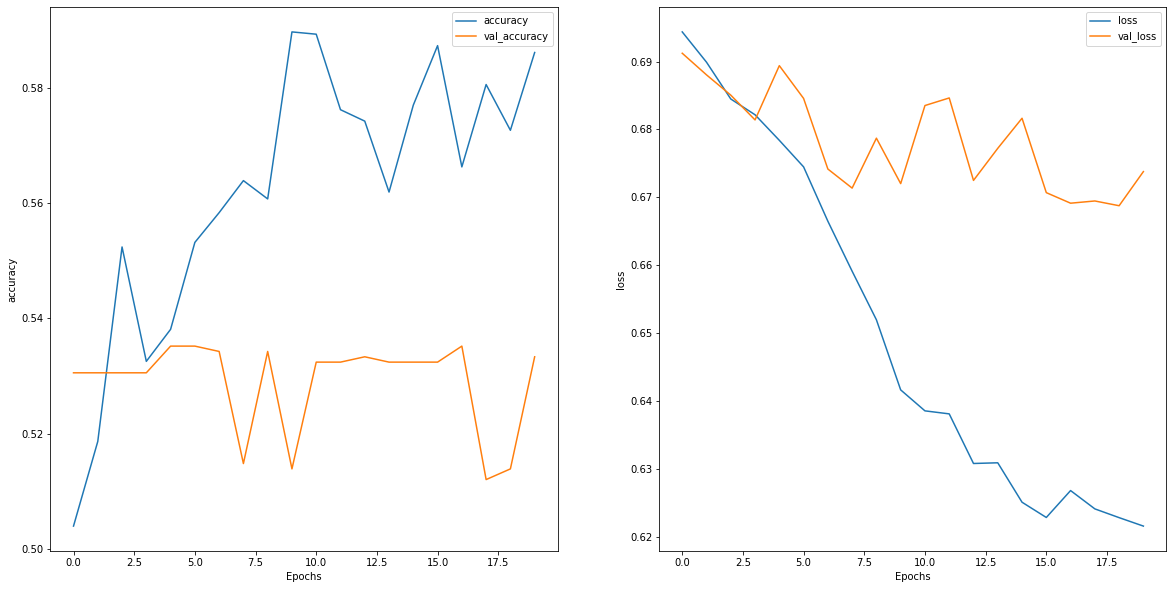

In [5]:
#繪製準確度變化與損失函數圖
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric],'')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_graphs(history,'accuracy')
plt.subplot(1,2,2)
plot_graphs(history,'loss')

In [6]:
#分類報告
prediction=(model.predict(x_test)>0.5).astype("int32")
print("分類報告: ",classification_report(y_test,prediction,digits=4))

分類報告:                precision    recall  f1-score   support

         0.0     0.8852    0.0980    0.1765       551
         1.0     0.5123    0.9868    0.6744       529

    accuracy                         0.5333      1080
   macro avg     0.6988    0.5424    0.4254      1080
weighted avg     0.7026    0.5333    0.4204      1080



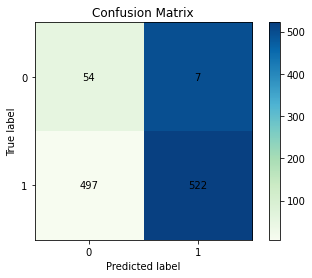

In [7]:
#繪製混淆矩陣
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y),horizontalalignment='center',verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True label')         
    plt.xlabel('Predicted label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.show()
confusion_mat=metrics.confusion_matrix(y_test,prediction,labels=None,sample_weight=None)
plot_confusion_matrix(confusion_mat)